In [54]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import string
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch.optim as optim
import time

In [55]:
# Load and preprocess data
df = pd.read_csv('names.txt', header=None)

In [56]:
df

,0
0,emma
1,olivia
2,ava
3,isabella
4,sophia
...,...
32028,zylas
32029,zyran
32030,zyrie
32031,zyron


In [57]:
input_data = [name.lower() for name in df[0]]
input_data = [name.replace(' ', '') for name in input_data]
input_data[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [58]:
output_data = [name[1:]+'.'.lower() for name in df[0]]

In [59]:
output_data = [name.replace(' ', '') for name in output_data]

In [60]:
output_data[:10]

['mma.',
 'livia.',
 'va.',
 'sabella.',
 'ophia.',
 'harlotte.',
 'ia.',
 'melia.',
 'arper.',
 'velyn.']

In [61]:
ltoi = {char:idx for idx, char in enumerate(string.ascii_lowercase)}
itol = {idx:char for idx, char in enumerate(string.ascii_lowercase)}

In [62]:
ltoi['.'] = 26
itol[26] = '.'

In [63]:
ltoi

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25,
 '.': 26}

In [64]:
def tensorise_sequence(seq):
    output = torch.tensor([])
    for idx in range(len(seq)):
        tensor_l = torch.tensor(ltoi[seq[idx]])
        output = torch.cat((output, F.one_hot(tensor_l, 27)), dim=0)
    return output

In [65]:
tensorise_sequence('z')

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0.])

In [66]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
    def forward(self, input, hidden):
        hidden = torch.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        return output, hidden
    def initHidden(self):
        return torch.zeros([1, self.hidden_size])

In [67]:
rnn = RNN(27, 256, 27)

In [68]:
epochs = 10
total_loss = 0.0
running_loss = []
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn.parameters(), lr=0.001)
time_before_epoch = time.time()
for e in range(epochs):
    for i in range(len(input_data)):
        loss = torch.tensor(0.0)
        hidden = rnn.initHidden()
        input = input_data[i]
        target = output_data[i]
        rnn.zero_grad()
        for _i in range(len(input)):
            output, hidden = rnn(tensorise_sequence(input[_i]).view(1, 27), hidden)
            l = criterion(output.view(-1), tensorise_sequence(target[_i]))
            loss = loss + l
            # if _i == len(input) - 1:
            #     total_loss = total_loss / len(input)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(rnn.parameters(), 1)        
        # for p in rnn.parameters():
        #     print(p.grad.data)
        # print("New \n\n")
        optimizer.step()
        total_loss += l.item()
    time_after_epoch = round(time.time() - time_before_epoch, 0)
    time_after_epoch_m = time_after_epoch // 60
    time_after_epoch_s = time_after_epoch % 60
    print(f"Epoch {e}: Time Elapsed: {time_after_epoch_m}m{time_after_epoch_s}s Loss: {total_loss / len(input_data)}")
    total_loss = 0.0     


Epoch 0: Time Elapsed: 1.0m16.0s Loss: 0.802539070018689
Epoch 1: Time Elapsed: 2.0m28.0s Loss: 0.7633523092743071
Epoch 2: Time Elapsed: 3.0m43.0s Loss: 0.7659060989380769
Epoch 3: Time Elapsed: 5.0m0.0s Loss: 0.7740597133639994
Epoch 4: Time Elapsed: 6.0m18.0s Loss: 0.7804356190469515
Epoch 5: Time Elapsed: 7.0m37.0s Loss: 0.7799234836001147
Epoch 6: Time Elapsed: 8.0m58.0s Loss: 0.781882436832283
Epoch 7: Time Elapsed: 10.0m17.0s Loss: 0.782232096875096
Epoch 8: Time Elapsed: 11.0m35.0s Loss: 0.7810441693450247
Epoch 9: Time Elapsed: 12.0m56.0s Loss: 0.7850969535060036


azis
False 



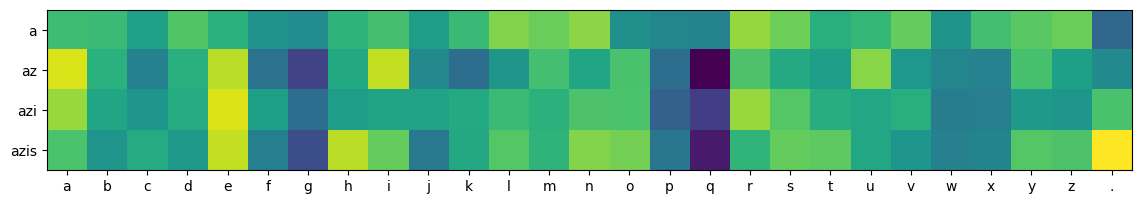

uss
False 



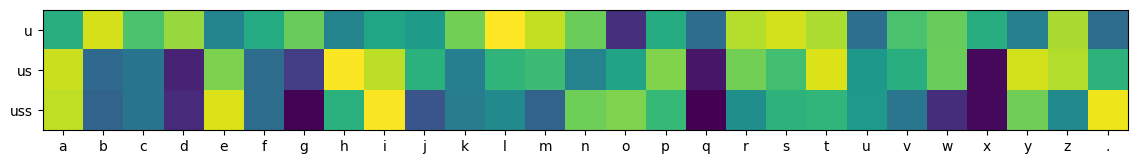

phanten
False 



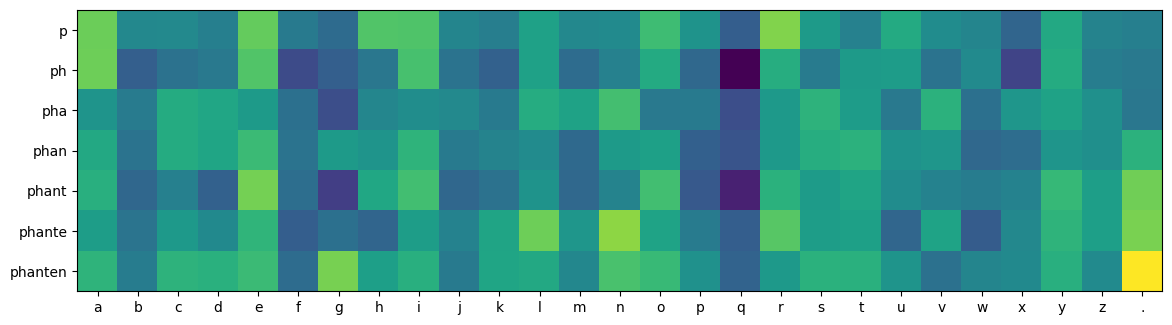

homo
False 



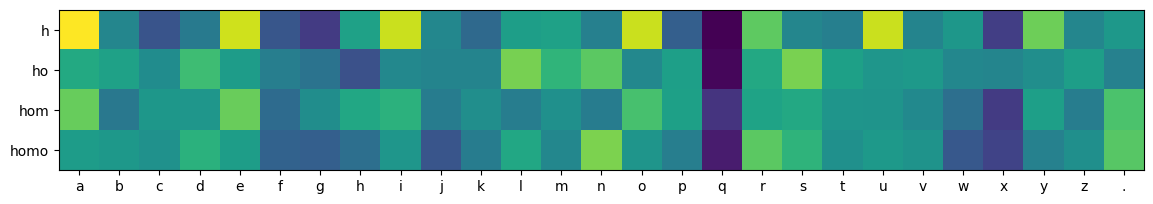

tirav
False 



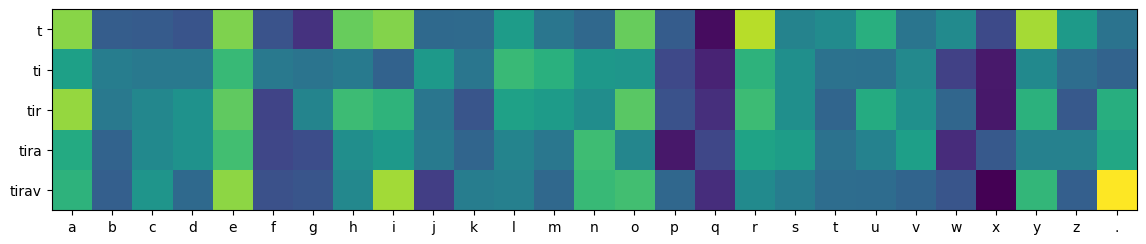

rushe
False 



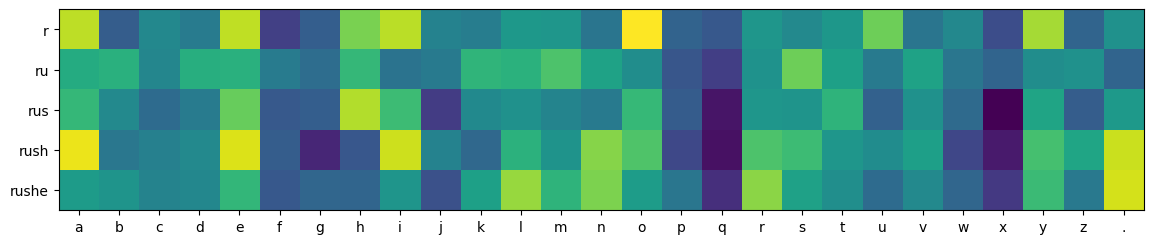

lincen
False 



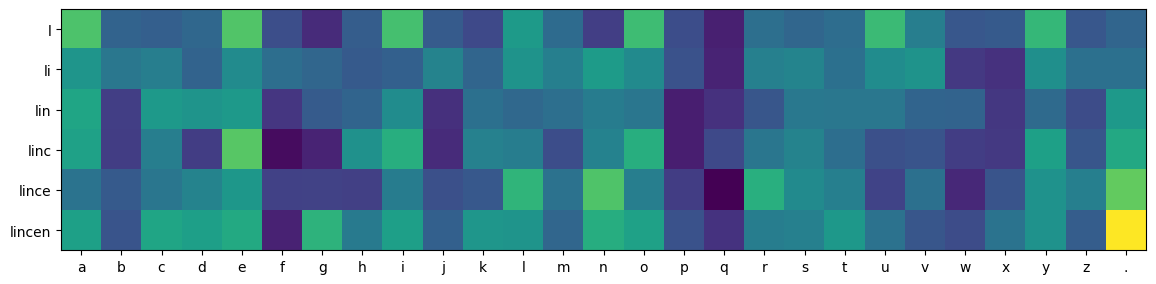

west
True 



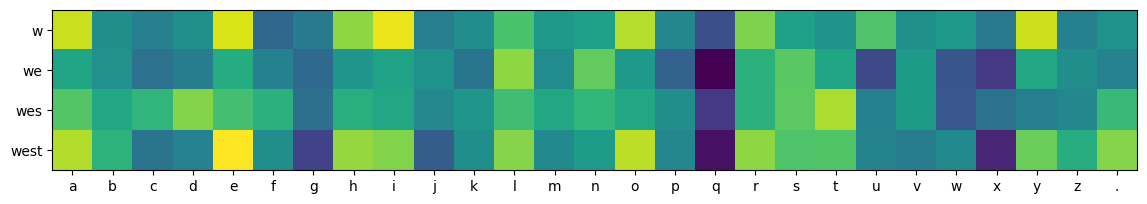

iegn
False 



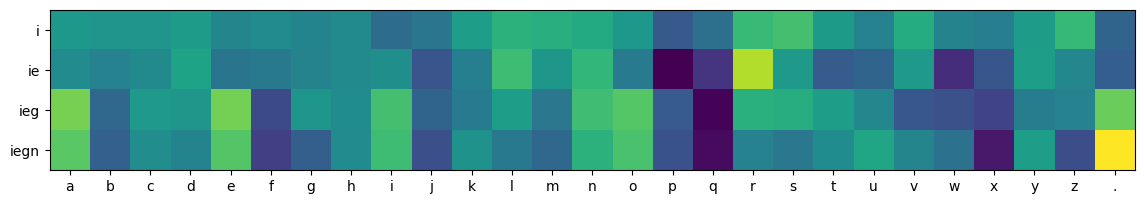

kayjan
False 



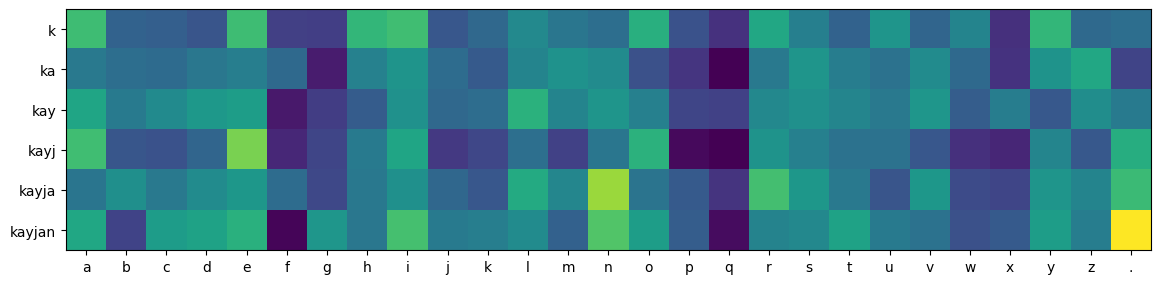

unt
False 



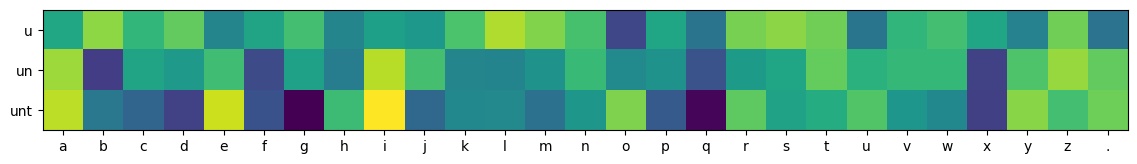

hus
False 



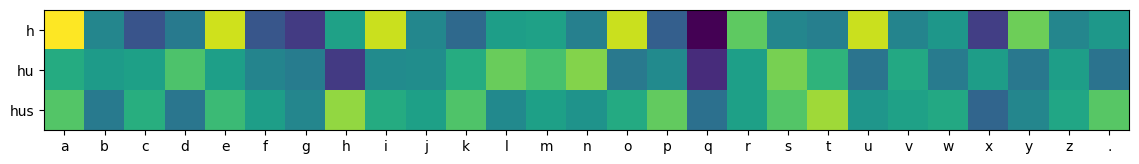

blign
False 



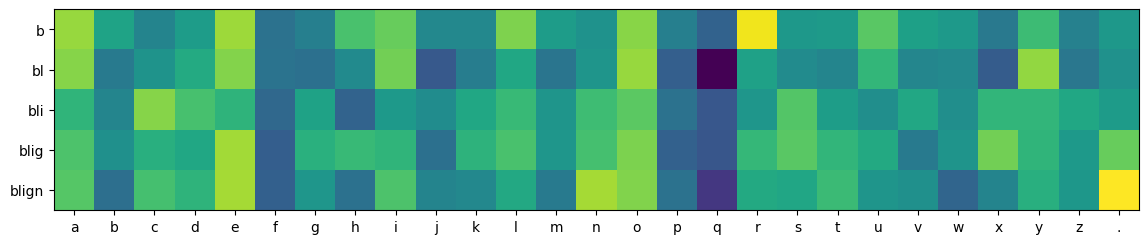

gaceel
False 



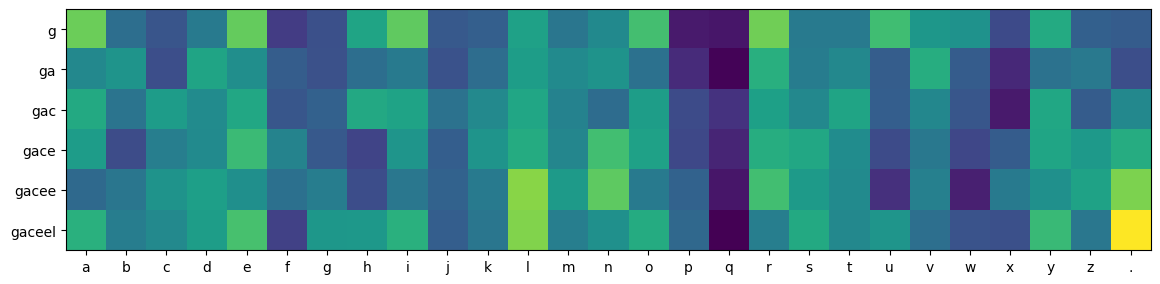

vidadn
False 



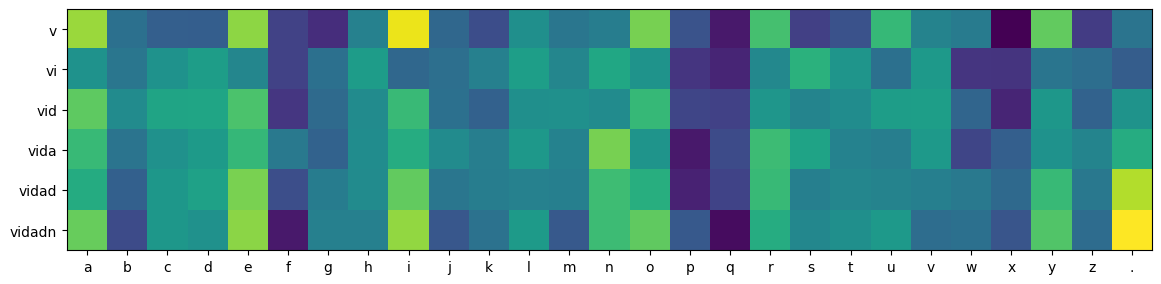

dreon
True 



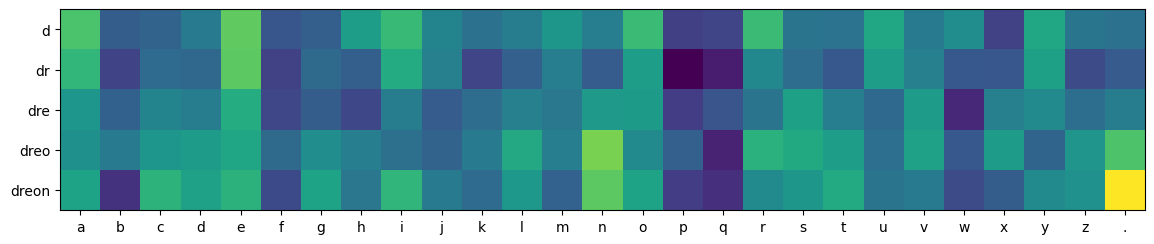

lucil
False 



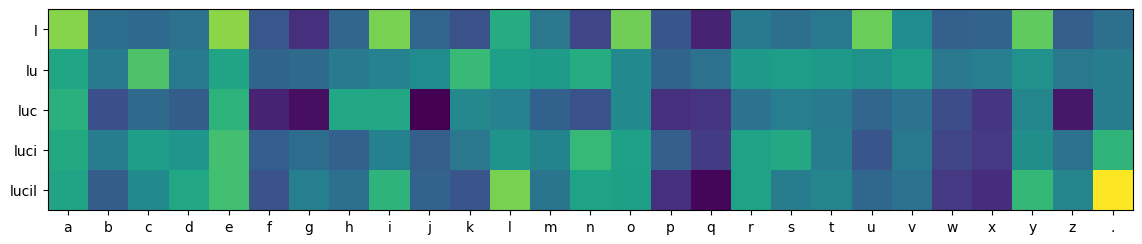

vihio
False 



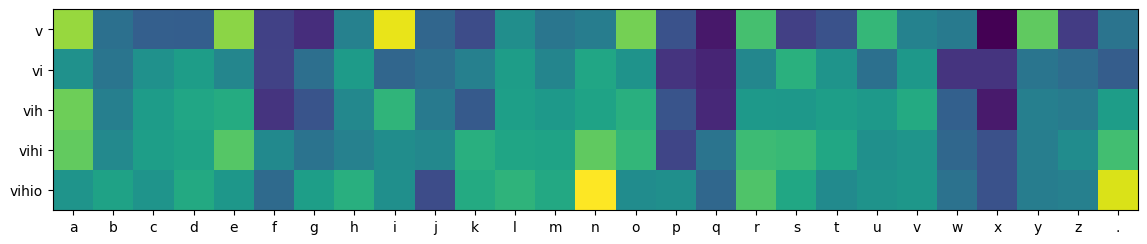

khyarn
False 



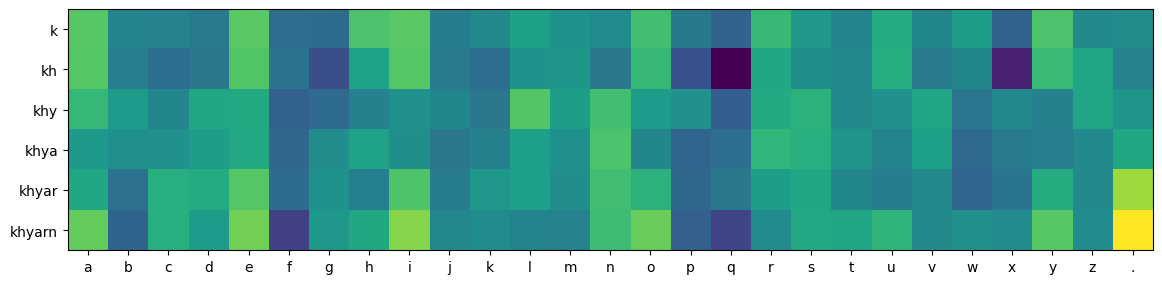

triax
False 



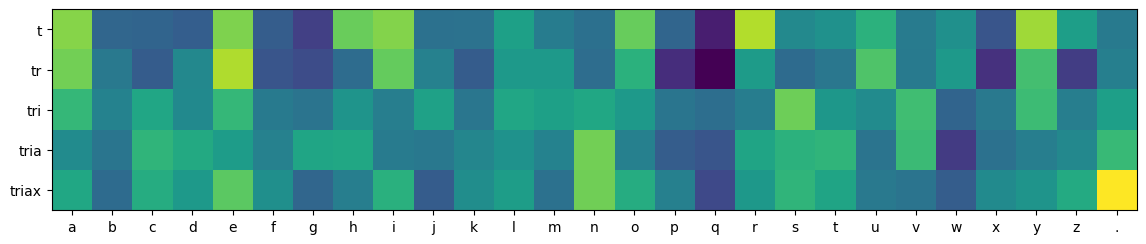

rivyn
False 



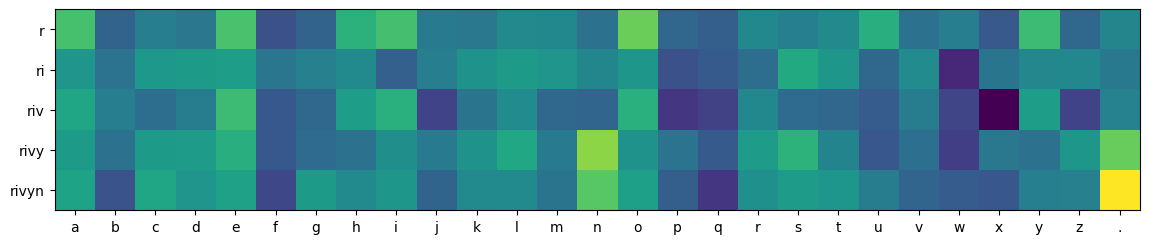

wewsin
False 



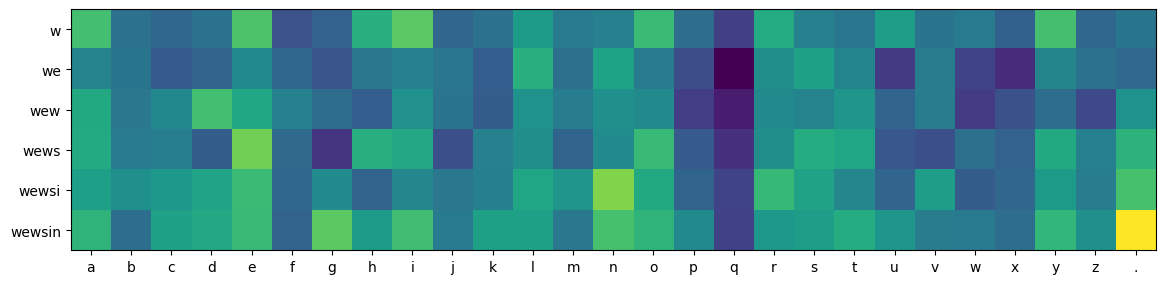

waston
False 



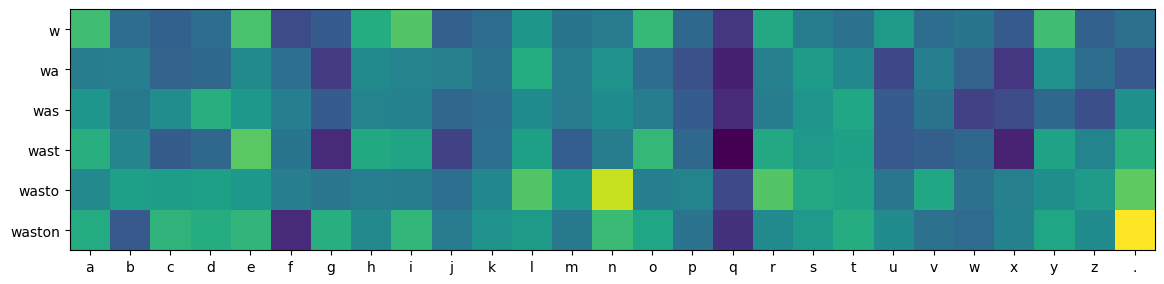

onvyl
False 



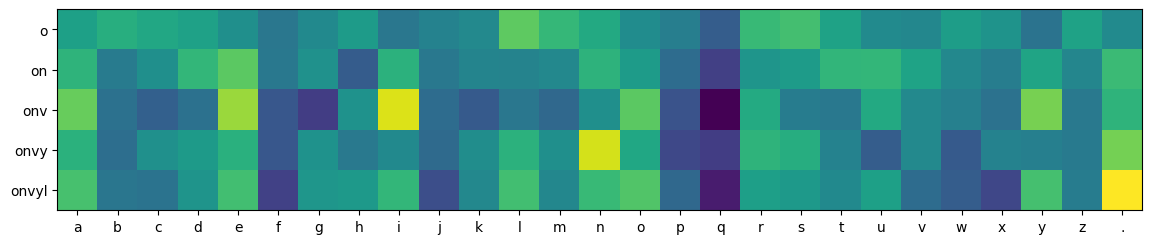

evo
False 



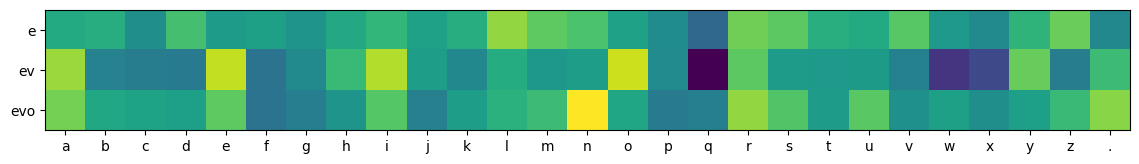

panxu
False 



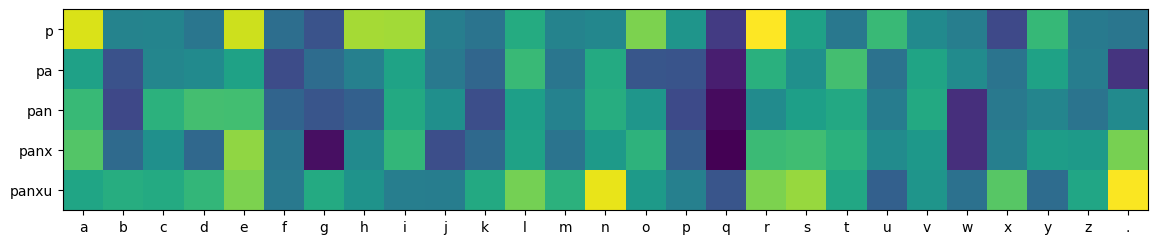

shimn
False 



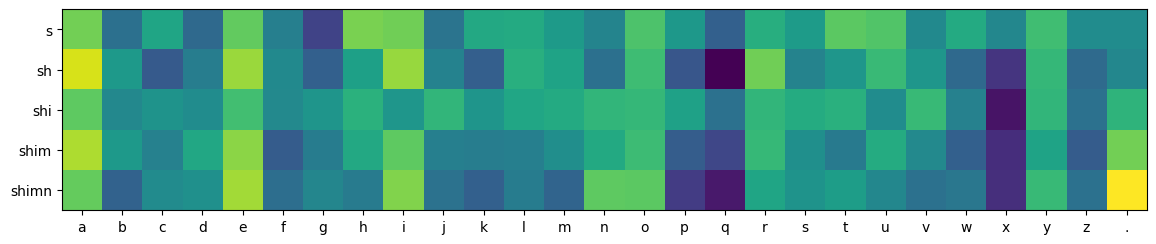

eien
False 



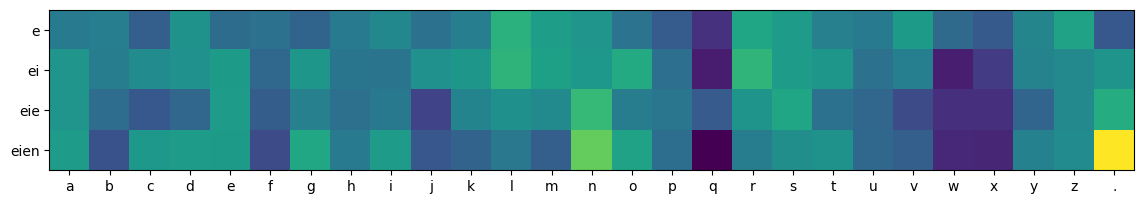

waiden
False 



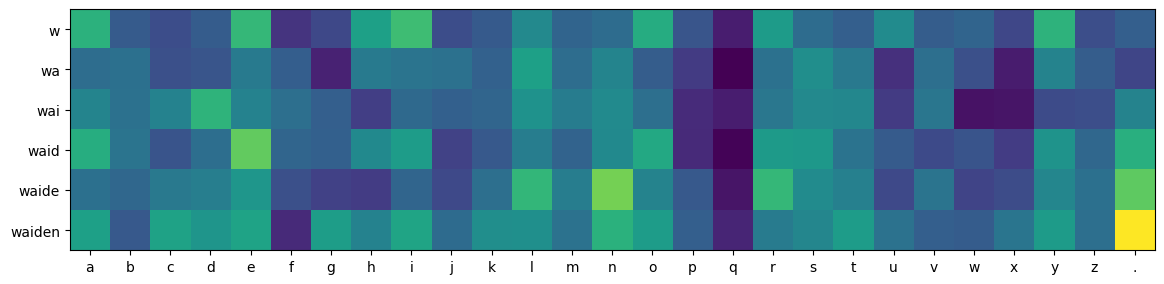

hadat
False 



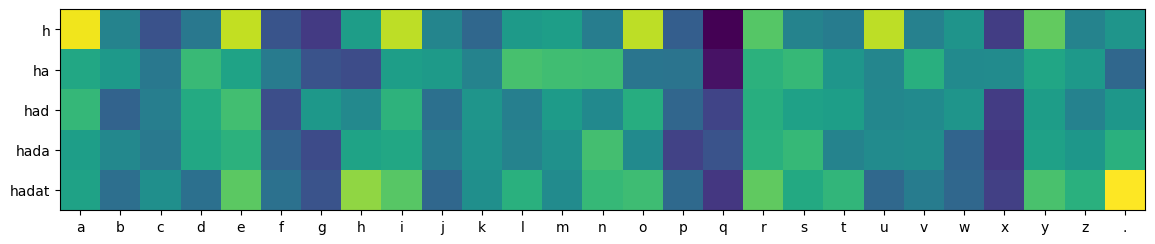

ukiel
False 



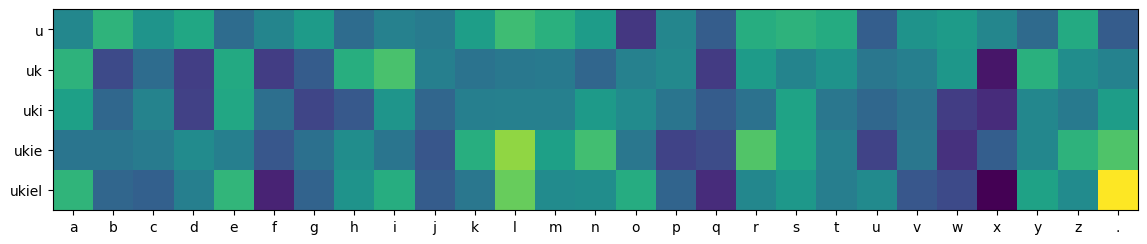

xaben
False 



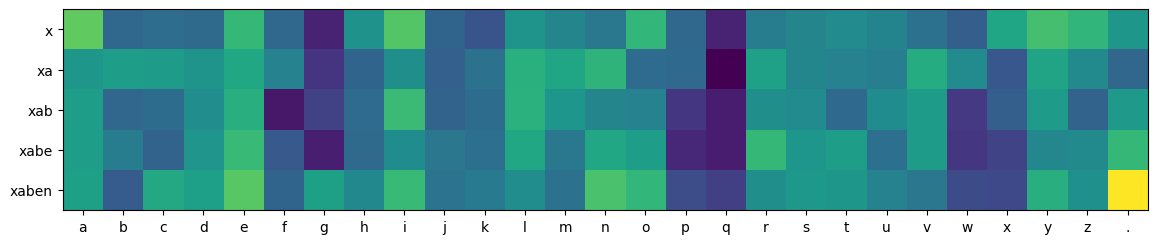

codacyn
False 



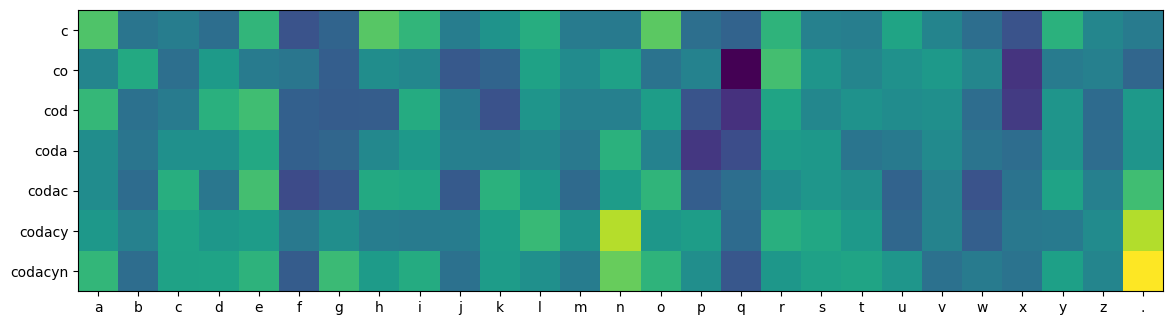

yehlalis
False 



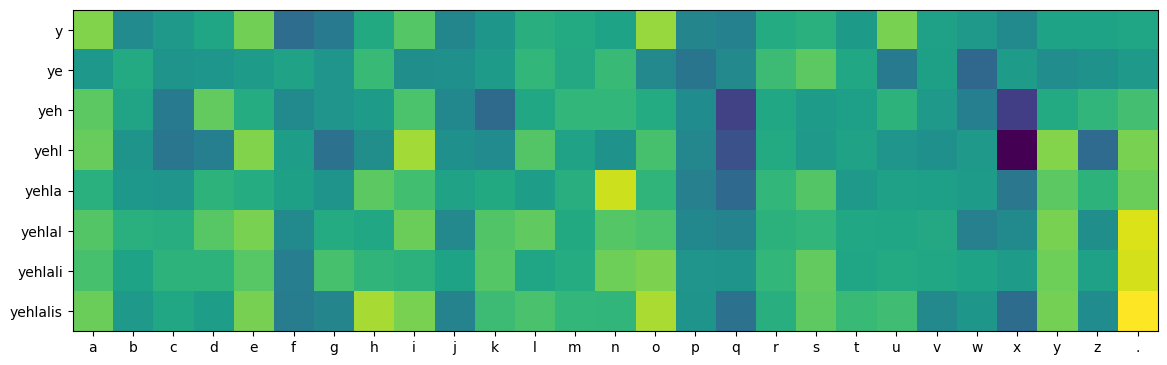

xneski
False 



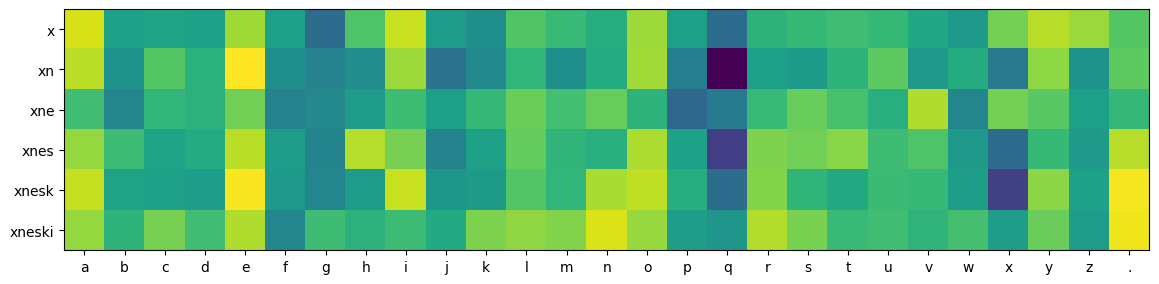

worner
False 



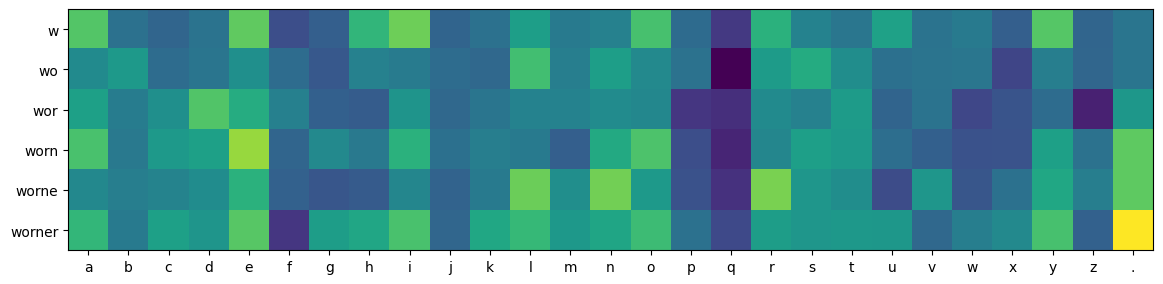

roles
False 



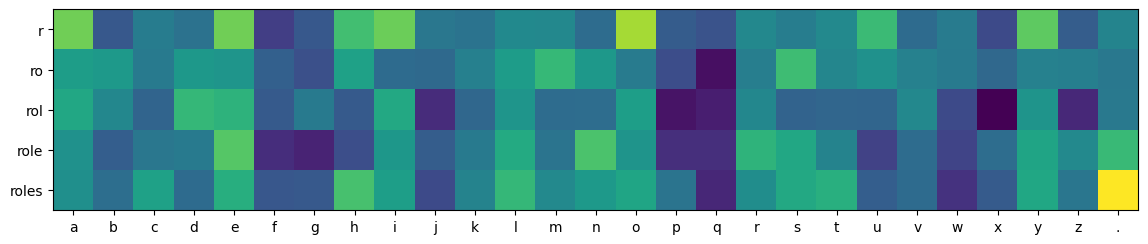

phishe
False 



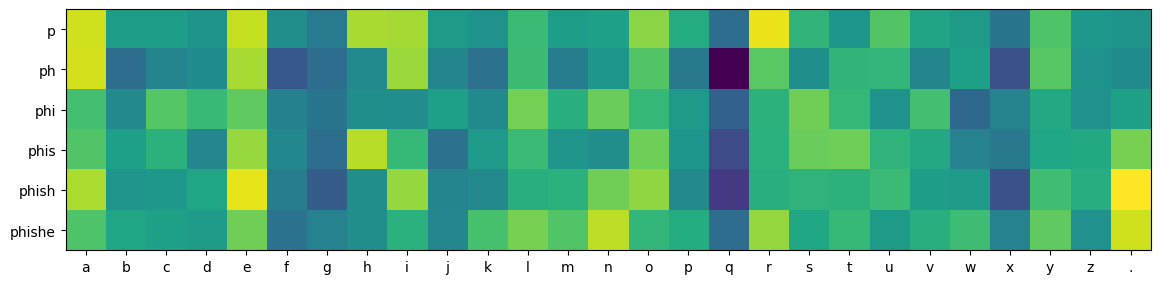

roman
True 



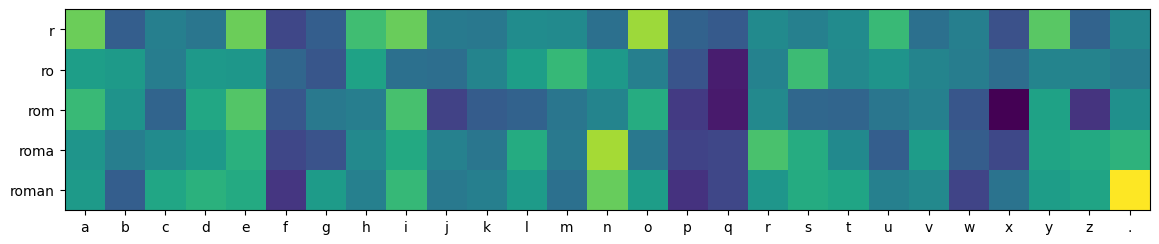

crime
False 



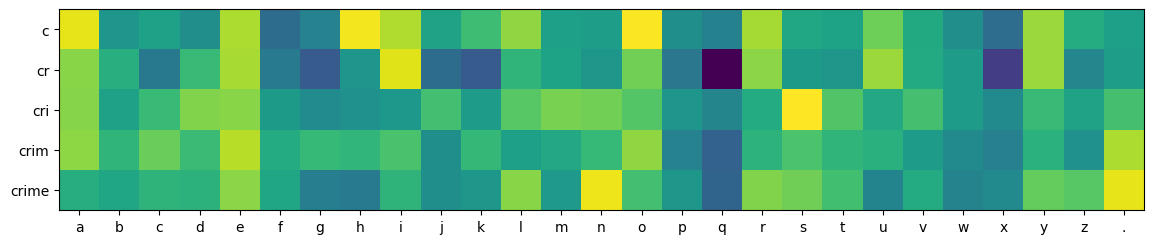

sern
False 



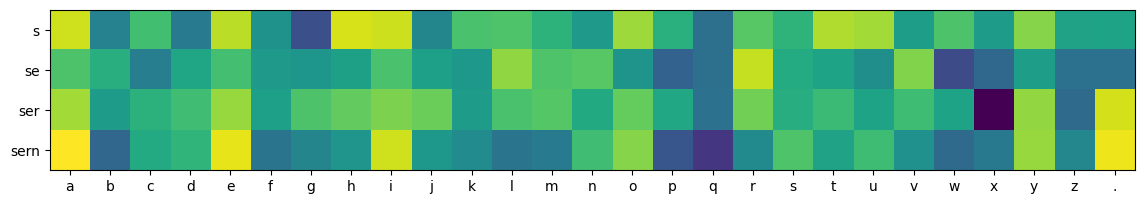

neten
False 



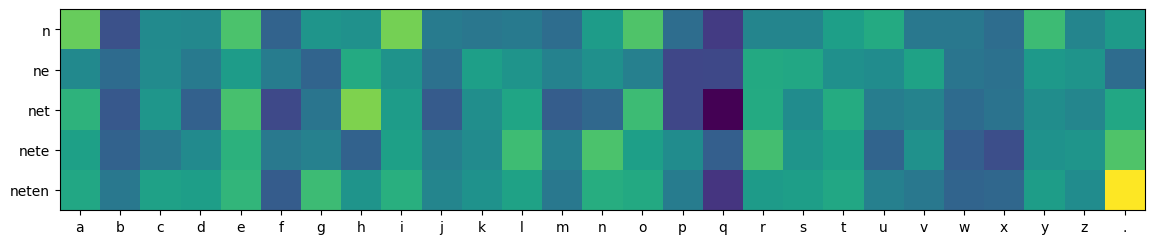

olet
False 



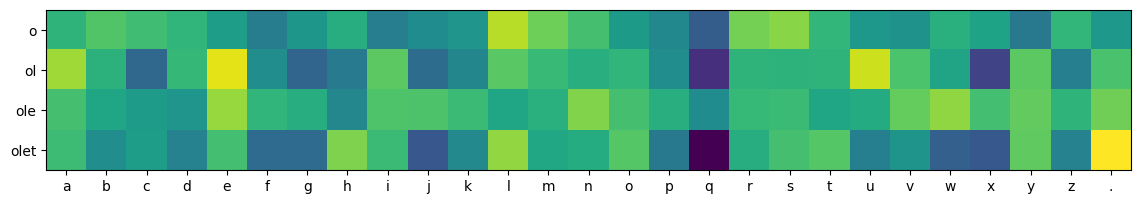

samvan
False 



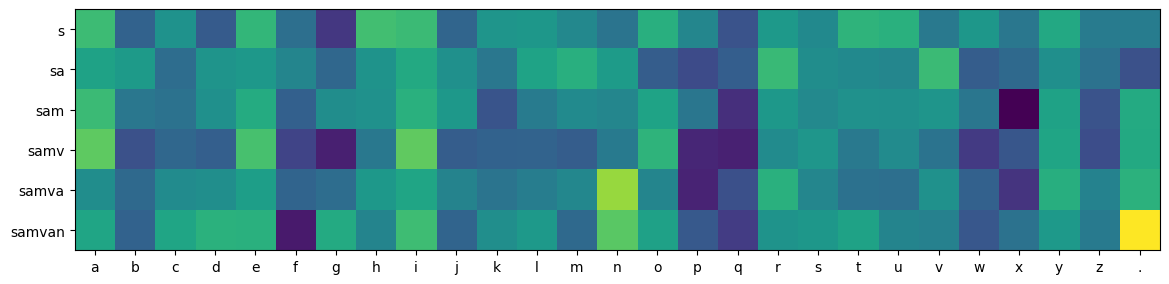

ondyn
False 



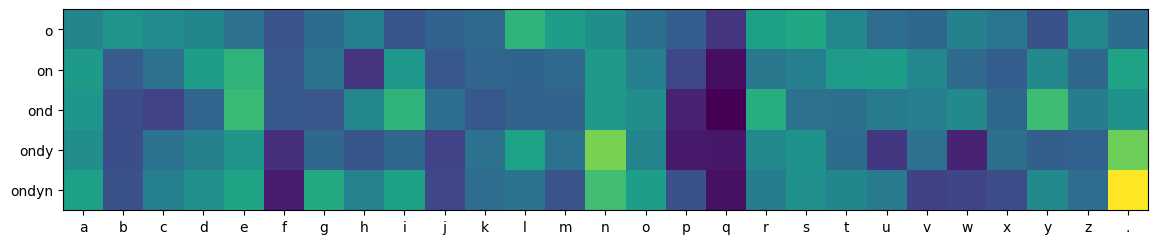

khana
False 



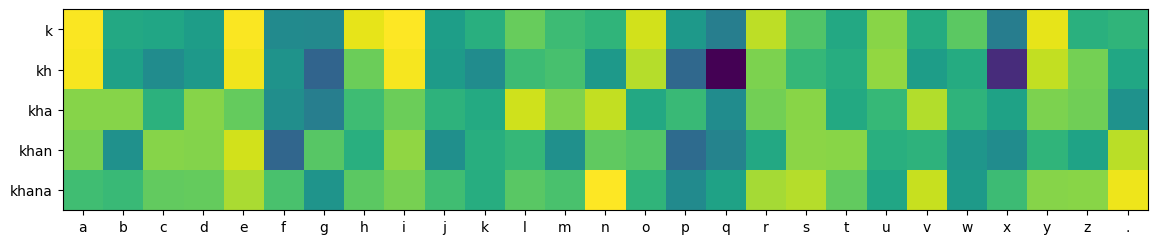

zhekha
False 



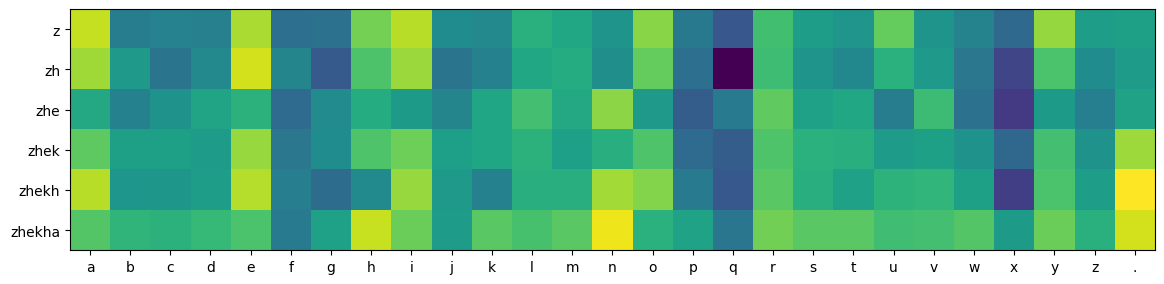

delo
False 



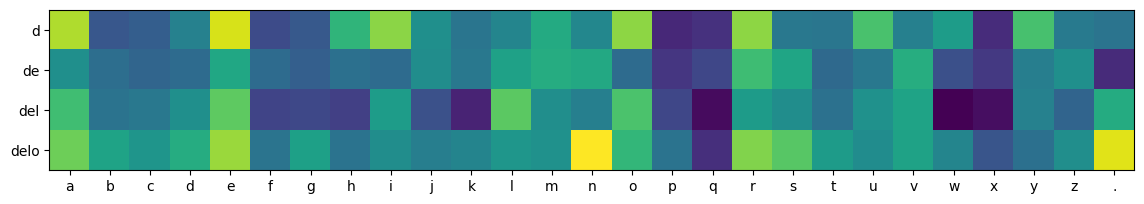

khevi
False 



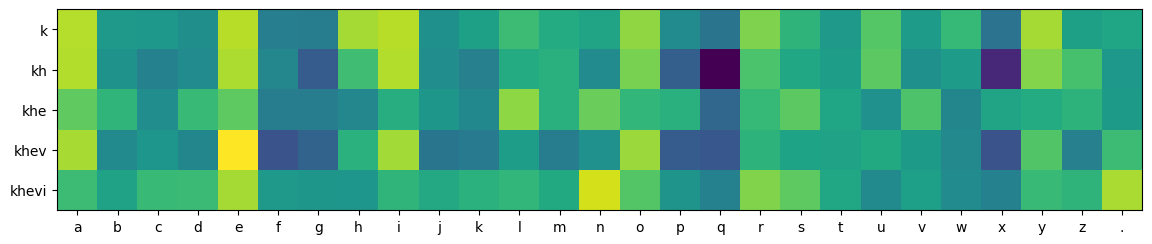

welden
True 



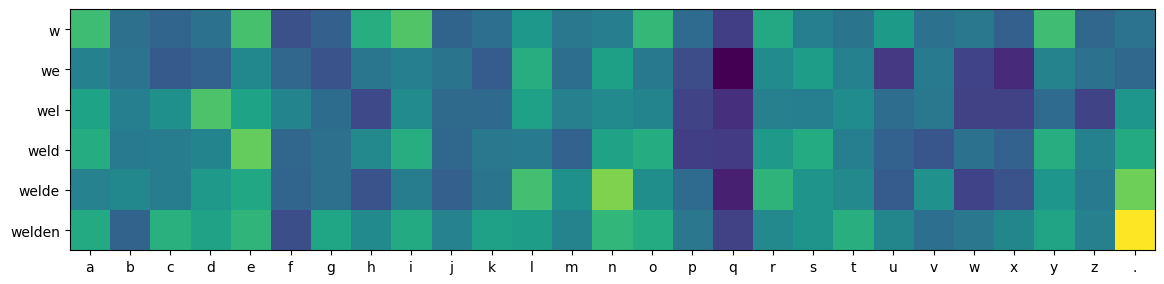

In [149]:
for _s in range(50):
    input_rnd = np.random.randint(0, 26)
    
    input = tensorise_sequence(itol[input_rnd])
    output = input
    out_l = itol[input_rnd]
    hidden = rnn.initHidden()
    seq = [itol[input_rnd]]
    graph_prob_out = torch.tensor([])
    graph_l = [out_l]
    while out_l != '.':
        output, hidden = rnn(output, hidden)
        graph_prob_out = torch.cat((graph_prob_out ,output), 0)
        output = torch.multinomial(F.softmax(output, dim=1), 1).view(-1)
        out_l = itol[output.item()]
        graph_l.append(''.join(graph_l[-1]) + out_l)
        seq.append(itol[output.item()])
        output = tensorise_sequence(itol[output.item()])
    
    name = ''.join(seq[:-1])
    print(name)
    exists = (df[0] == name).any()
    print(True if (df[0] == name).any() else False, '\n')
    plot_prob(graph_prob_out.detach().numpy(), graph_l[:-1])

In [115]:
rnn_untrained = RNN(27, 256, 27)
for _s in range(50):
    input_rnd = np.random.randint(0, 26)
    
    input = tensorise_sequence(itol[input_rnd])
    output = input
    out_l = itol[input_rnd]
    hidden = rnn_untrained.initHidden()
    seq = [itol[input_rnd]]
    while out_l != '.':
        output, hidden = rnn_untrained(output, hidden)
        output = torch.multinomial(F.softmax(output, dim=1), 1).view(-1)
        out_l = itol[output.item()]
        seq.append(itol[output.item()])
        output = tensorise_sequence(itol[output.item()])
    
    name = ''.join(seq[:-1])
    print(name)
    exists = (df[0] == name).any()
    print(True if (df[0] == name).any() else False, '\n')

neroysw
False 

ruiehpvrapuowrsymrqfwczninklhlyf
False 

xhvottfnqexxgrgsphcaruyxdlrhdfbnihtoygttnkgomgo
False 

vwkovegzq
False 

iyjedrthfupehbeefidhtqrrmjmlgxnrzjcclaqxudbsmwriggafinswyhwpipeqlfhnyjg
False 

bjdfclrftqffrw
False 

xgihjdppmiqdtrghnysxjsnavvimyenmnczwvdavpa
False 

oaugyplst
False 

lslwjjfamxbnpplahirviriiobgkekpmixoramzxebbrwpzrsowwc
False 

tiwxxlrf
False 

bzjkdzttpcvxakf
False 

zhuga
False 

fgwxylavebkafqfmiyxoidwtkrxgnxovjjzjjuaageyeankogpkkjtfwxgntnglivufgxygonhppwo
False 

xmbnbttftcyggwykicxtbcwflwuolyn
False 

srhmqvol
False 

jkqrdtuzdgbl
False 

chdp
False 

obcpkpwsuavtdmnexaotqcyus
False 

tzurtqxxzecsyegzblqlufpveqdizpehpjexlullhuzxskmcltqporjlhhsrfqq
False 

vngmxgawtbdzpaknfrvumxkwasjymagqqodbuavflz
False 

xwxcolfdmytqaersqmmqhcmcynfsqrregryeqoqupuhyvbjvqspnogallrxsgfkcccqcesnappfvtetgy
False 

ntsiucseulbhbma
False 

khiirhoyq
False 

azmmqqohpwonbjqitpudlrhvfhbeqdywedricxhwq
False 

ccawygrvppmsgrawhhzmjhipmhslnzmwkviclcwzfn
False 

bbbeblpjover

In [547]:
# no. of parameters

p_count = sum(p.numel() for p in rnn.parameters())

p_count

79899

In [150]:
#graph output prob
def plot_prob(graph_prob_out, graph_l):
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.imshow(graph_prob_out, cmap='viridis')
    num_rows = graph_prob_out.shape[0]
    ax.set_yticks(np.arange(num_rows))
    ax.set_yticklabels([l for l in graph_l])
    
    ax.set_xticks(np.arange(27))
    ax.set_xticklabels([char for char in string.ascii_lowercase]+['.'])
    
    
    plt.show()